# This notebook is for inference on test data given in the interview

## Load libraries

In [1]:
import utils
from feature_engineering import FeatureEngineering
import metrics

In [2]:
import pandas as pd
import numpy as np
import metrics
import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pickle
import glob
import joblib

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

/home/ntng/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Declare path to test data

In [4]:
# we define the path to the test dataset
path_to_test_data = 'testdata'# 'testdata'

## Internal processing

In [5]:
# here are some internal constants
path_to_data4dev = 'assets/data4dev.csv'
path_to_data_scaler = 'assets/data_scaler.pkl'
path_to_data_inf_org = 'assets/path_to_data_orig_inf.csv'
path_to_data_inf_transformed = 'assets/path_to_data_dev_inf.csv'
model_path = {'xgb': 'results/xgb_model.pkl'}


In [6]:
# load data
df = utils.load_data(nonfraud_path=glob.glob(f"{path_to_test_data}/*_nonfraud_*.csv"), fraud_path=glob.glob(f"{path_to_test_data}/*_fraud*.csv"))
df.to_csv(path_to_data_inf_org, index=False) # we need to store this for report generation

In [7]:
# transform data
fe = FeatureEngineering(df)
transformed_df = fe.transform() 
transformed_df.to_csv(path_to_data_inf_transformed, index=False)

In [8]:
# prepare data for inference
col_to_drop = ['id', 'fraud']
X = transformed_df.drop(col_to_drop, axis=1)
y = transformed_df['fraud']


In [9]:
# scale data
data_scaler = joblib.load(path_to_data_scaler)
X_standardized = data_scaler.transform(X)

In [10]:
model_to_use = 'xgb'
clf = utils.load_model(model_path[model_to_use])
model = model_to_use + '_test'

if model_to_use in ['lr', 'dt']:
    y_pred = clf.predict(X_standardized)
elif model_to_use == 'xgb':
    dtest = xgb.DMatrix(X_standardized, label=y, feature_names=X.columns.tolist())
    y_pred_proba = clf.predict(dtest)    

# Evaluate models and generate report

In [11]:
# Try to find the optimal threshold using F2 scores
# Reference: https://www.giskard.ai/glossary/f-score#:~:text=The%20F%2D2%20score%20is,2%20*%20precision%20%2B%20recall).
from sklearn.metrics import precision_recall_curve, fbeta_score

precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)

# f2 score
precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
f2_scores = (5 * precision * recall) / (4 * precision + recall)
f2_scores = np.concatenate([[0], f2_scores])  # Add 0 for the last threshold (threshold=0)

# Find the threshold that maximizes the F2 score
optimal_threshold = thresholds[np.argmax(f2_scores[1:])]  # Ignore the first threshold (for threshold=0)

# Classify predictions with the optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)


F1: 0.65625
AUC ROC: 0.8499940763476764
AUC PR: 0.43236114293237543
Sensitivity (Recall): 0.7
Specificity: 0.9999881526953529


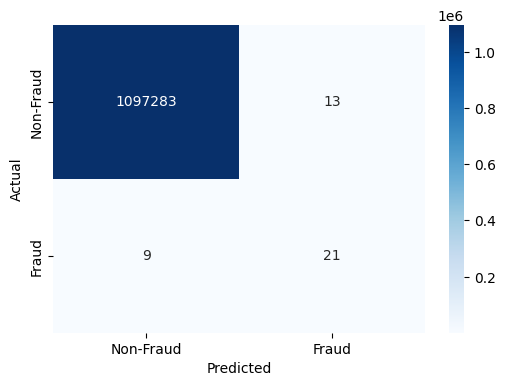

array([[1097283,      13],
       [      9,      21]])

In [12]:
print("F1:", metrics.calc_f1(y, y_pred))
print("AUC ROC:", metrics.calc_auc_roc(y, y_pred))
print("AUC PR:", metrics.calc_auc_pr(y, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y, y_pred))
print("Specificity:", metrics.calc_specificity(y, y_pred))
metrics.generate_confusion_matrix(y, y_pred, 'result_on_test/confusion_matrix.png')

I can see the performance on the test have some false negatives and false postives. Given the fact that Recall is 0.7, I think there is room for improvement. I already tried to find the optimal threshold using F2 score which balance precision and recall but put more focus on recall.

In [13]:
# The report can be found at prediction_report.csv
if model_to_use in ['lr', 'dt']:
    y_pred_proba = clf.predict_proba(X_standardized)
elif model_to_use == 'xgb':
    y_pred_proba = y_pred_proba.reshape((-1, 1))
    y_pred_proba = np.hstack([np.zeros((y_pred_proba.shape[0], 1)), y_pred_proba])
    
utils.generate_prediction_report(path_to_data_inf_org, path_to_data_inf_transformed, 
                                 y, y_pred, y_pred_proba, 
                                 'result_on_test/prediction_report.csv')

,id,sender_id,receiver_id,amount,status,flowname,bankfees,timestamp,sender_age,receiver_age,fraud,fraud_predicted,fraud_predicted_proba,fraud_rank
1137620,49f3f8fb4b9720a08c5c57940487c6fd,9cde10a283f4c0e7d47d5e872e2a757d,68875fb5ba57030e9ecfeb674649217d,4600.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-06-24 19:12:19.466062+00:00,77,42,1,1,0.999999,1
1137621,de8efe7c02d565efbf6a3e1ba966a568,9cde10a283f4c0e7d47d5e872e2a757d,68875fb5ba57030e9ecfeb674649217d,4600.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-06-24 19:07:33.709995+00:00,77,42,1,1,0.999999,2
1137622,deca5e00cdfe11de14b4558b7b019956,9cde10a283f4c0e7d47d5e872e2a757d,68875fb5ba57030e9ecfeb674649217d,4600.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-06-24 19:11:46.860648+00:00,77,42,1,1,0.999999,3
1137630,ac93767d712f3f73a2c9de037e9764af,9cde10a283f4c0e7d47d5e872e2a757d,68875fb5ba57030e9ecfeb674649217d,4600.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-06-24 19:13:52.775954+00:00,77,42,1,1,0.999999,4
1137631,9ea34963f8aac0d11576f3856b8e0c4f,13cfa12c02b69a5013a43c9aa6ebf3d4,4a1c1702d56e493ba499c7b94be7d71f,4700.0,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-06-23 21:48:54.055563+00:00,84,17,1,1,0.999999,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42882,0cac92a64773482c8f44e376bdabec59,62fe78acc5875ee03024bc7980b9e9d0,62fe78acc5875ee03024bc7980b9e9d0,900.0,PaymentSucceededV0,0b303e3880e0cd3a9f6033ee4b65cccc,0.0,2024-06-07 21:42:41.022250+00:00,18,18,0,0,0.339766,1137644
42884,0cac92a64773482c8f44e376bdabec59,62fe78acc5875ee03024bc7980b9e9d0,62fe78acc5875ee03024bc7980b9e9d0,900.0,PaymentSucceededV0,0b303e3880e0cd3a9f6033ee4b65cccc,0.0,2024-06-07 21:42:41.022250+00:00,18,18,0,0,0.339766,1137645
432742,cda414f7fe5fccdf154eabe6f27f0a8b,d3bf1dedbb9e2d7d9591c14832f9f56d,4f6f3a9b69865a9fcee06d3d1b594737,1000.0,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-06-07 21:42:14.009389+00:00,25,29,0,0,0.339766,1137646
432744,cda414f7fe5fccdf154eabe6f27f0a8b,d3bf1dedbb9e2d7d9591c14832f9f56d,4f6f3a9b69865a9fcee06d3d1b594737,1000.0,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-06-07 21:42:14.009389+00:00,25,29,0,0,0.339766,1137647


In [14]:
# Below is the list of false negatives and false positives. 
# I hope we can make it better at Vipps MobilePay
false_predictions = metrics.identify_false_predictions(path_to_data_inf_org, path_to_data_inf_transformed, y, y_pred)
false_predictions.T

,13810,85632,86427,91300,245292,251073,559168,763575,816761,817609,...,1052131,1137618,1137625,1137627,1137628,1137634,1137637,1137638,1137639,1137640
id,867e8578cecefbecbd9c4d8d81bf10f6,f0a2f71f5568de708c04d11b37605ab9,ab7ff52e4a46e244ad1041e64ab4740f,29e52ed5d3a3468eebcc59bf785aa247,b31e64687121932b95d64d7d32fbe9cf,2bbb7938c02fac234df6622b26718f32,d3d84abf2f390f8e0976e50dab66ddb9,53c08229096b28329e5d2f876380c545,2216558e58e3139a7057b2a3ea3dcad2,c98e1b5dd11d6ff365575ce75c3afc8f,...,ca775b01f3663a879581cad316274c29,f80eca364b97cb87b03478498b2eea53,d9f1c7b35656d481c382d0896adc0423,d790ee6210c359f32dfdb3d00b751efb,646e4cb9fa912c1388293b8087a110ae,30a531602e0417e88993f7136d533e42,b201b283bcab9da8253b28dce632696e,690762ed2a192e762cf1ec59079b1793,67397c3007c262013a250a1c40419bed,c7e74b4d72408c84a55bd030a3ee109c
sender_id,d59813bde3104ecf4d50590031c406e4,bb2f7d8f41d12f0602aaf83df69751b0,f43ad916009e5381eb98ae6da3f90978,4c326fb2923501edd42973693c4482cd,f9f2d35ded4b8d939a057b7f3c71a53d,855637c87a900b23d578dc6f88fa0a9e,1a1bd0f2af7c014e74feaf83987c1222,0a64fbc32b4f03cdc0fd4905a459edc6,243a70efe313359fd0e73d25b1bb5f65,f9f2d35ded4b8d939a057b7f3c71a53d,...,a67d2877d7cad12890fb5bcf0393271e,e4d9c60f688af0b5d4fa9af9e579dc56,88b995024fb9ee5307d9e11f41b73d25,391e8609f6b62b2f0ea88e1a5f95428c,391e8609f6b62b2f0ea88e1a5f95428c,bf4e0bcc86b0aa817117d8db33b57fc6,357496362b816d37e3bba786b8f8b2c5,357496362b816d37e3bba786b8f8b2c5,357496362b816d37e3bba786b8f8b2c5,c56837bae84f8e32034c11d636ad3eee
receiver_id,a3a21129398db27ffbb17f4f83cdefcb,222e4df285f8dbc106a6b5c3700f76e4,cf5334b4cb995d2937f07d434b810d73,221dd05b37943f7431c56afe4d5fe2ad,137919346cc3420e456cb04c3fbbf6a9,8661e0c566cab27b7d7de5b2f11b2497,c028a30dbd3685321c1180b90dc31dbb,58b938add64302a6bc8f0dff6f6b6827,e38e1237458e8fe9bd036e5806a91a26,137919346cc3420e456cb04c3fbbf6a9,...,11a8ad8c77a6a5e4f04c40c0700cafda,8a178326ceafc3658368d75042da9f25,35ed2aaaf83404bd7b515070e7ace6a9,d548d56705a5d6b05bd17cb76e6885ba,d548d56705a5d6b05bd17cb76e6885ba,0f3e32ae5e31bf5a59bd7e2a478ae67f,917152af08683f090e57780f7e864077,917152af08683f090e57780f7e864077,917152af08683f090e57780f7e864077,7ec626e20b7c939cc57391c37a86cf90
amount,4000.0,2924.0,3298.0,3025.0,5000.0,5155.0,2306.0,1555.0,2700.0,5000.0,...,10000.0,4999.0,10000.0,2799.0,4000.0,3000.0,4904.0,4905.0,4910.0,999.0
status,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,...,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0
flowname,06a380d2a2da7b3c0553297dd2b6c18c,233046f509c582591ff83d0915e07895,233046f509c582591ff83d0915e07895,06a380d2a2da7b3c0553297dd2b6c18c,e395101288f53121cee2480bc7f24c4b,06a380d2a2da7b3c0553297dd2b6c18c,e395101288f53121cee2480bc7f24c4b,06a380d2a2da7b3c0553297dd2b6c18c,e395101288f53121cee2480bc7f24c4b,e395101288f53121cee2480bc7f24c4b,...,e395101288f53121cee2480bc7f24c4b,6e85ede9cf5197f7fa5f36a85a8a6adc,06a380d2a2da7b3c0553297dd2b6c18c,06a380d2a2da7b3c0553297dd2b6c18c,06a380d2a2da7b3c0553297dd2b6c18c,233046f509c582591ff83d0915e07895,e395101288f53121cee2480bc7f24c4b,e395101288f53121cee2480bc7f24c4b,e395101288f53121cee2480bc7f24c4b,e395101288f53121cee2480bc7f24c4b
bankfees,0.0,0.0,0.0,0.0,0.0,7500.0,0.0,0.0,0.0,0.0,...,7500.0,0.0,7500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timestamp,2024-06-07 17:42:18.043459+00:00,2024-06-07 16:59:12.906072+00:00,2024-06-07 17:05:05.002283+00:00,2024-06-07 17:42:43.984415+00:00,2024-06-07 17:09:09.315885+00:00,2024-06-07 17:56:24.177694+00:00,2024-06-07 16:57:07.866878+00:00,2024-06-07 16:21:57.721314+00:00,2024-06-07 16:52:45.983906+00:00,2024-06-07 16:57:27.897499+00:00,...,2024-06-07 16:05:16.751401+00:00,2024-06-19 13:48:09.382821+00:00,2024-06-07 16:10:41.883386+00:00,2024-06-07 09:58:11.504662+00:00,2024-06-05 22:17:18.504825+00:00,2024-